In [1]:
import scanpy as sc 
import matplotlib.pyplot as plt
import os
import seaborn as sns
import numpy as np
import anndata as ad
import pandas as pd
from scipy import stats
os.system("clear")

###############
data_dir="/goofys/users/Aleksandra_S/benchmarking_datasets/"
###############

In [23]:
adata_s1 = ad.read_h5ad(f"{data_dir}E9.5_E2S1.MOSTA.h5ad")

In [37]:
adata_s1.X.data

array([2.866716 , 2.866716 , 2.866716 , ..., 4.209409 , 7.6668773,
       9.05282  ], dtype=float32)

In [33]:
adata_s1.X.sum(axis=1)

matrix([[1199.7817  ],
        [3319.4658  ],
        [3665.1257  ],
        ...,
        [1315.3643  ],
        [ 505.96512 ],
        [  16.719698]], dtype=float32)

##  Data Cleaning

In [38]:
# mitochondrial genes
adata_s1.var["mt"] = adata_s1.var_names.str.startswith("MT-")
adata_s1.var["mt"] = adata_s1.var_names.str.startswith("mt-")

In [39]:
sc.pp.calculate_qc_metrics(
    adata_s1, qc_vars=["mt"], inplace=True, percent_top=[20], log1p=True
)
adata_s1

AnnData object with n_obs × n_vars = 5292 × 23756
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'annotation', 'Regulon - 3830417A13Rik', 'Regulon - 4921509C19Rik', 'Regulon - 9130019O22Rik', 'Regulon - Acaa1a', 'Regulon - Alx3', 'Regulon - Alx4', 'Regulon - Arnt2', 'Regulon - Arntl2', 'Regulon - Arx', 'Regulon - Ascl1', 'Regulon - Ascl2', 'Regulon - Atf1', 'Regulon - Atf2', 'Regulon - Atf3', 'Regulon - Atf6', 'Regulon - Atf6b', 'Regulon - Atoh1', 'Regulon - Bach1', 'Regulon - Bach2', 'Regulon - Barhl1', 'Regulon - Barx2', 'Regulon - Batf', 'Regulon - Batf3', 'Regulon - Bcl11a', 'Regulon - Bcl11b', 'Regulon - Bcl3', 'Regulon - Bclaf1', 'Regulon - Bhlhe40', 'Regulon - Bmyc', 'Regulon - Borcs8', 'Regulon - Bptf', 'Regulon - Brca1', 'Regulon - Brf1', 'Regulon - Brf2', 'Regulon - Cbfb', 'Regulon - Cd59a', 'Regulon - Cdx1', 'Regulon - Cdx2', 'Regulon - Cdx4', 'Regulon - Cebpa', 'Regulon - Cebpb', 'Regulon - Cebpg', 'Regulon - Cers6', 'Regulon 

/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


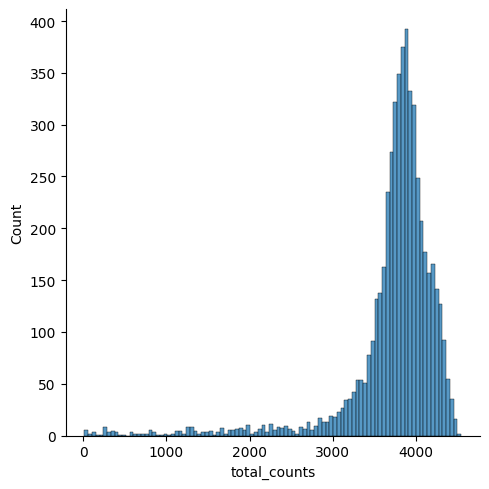

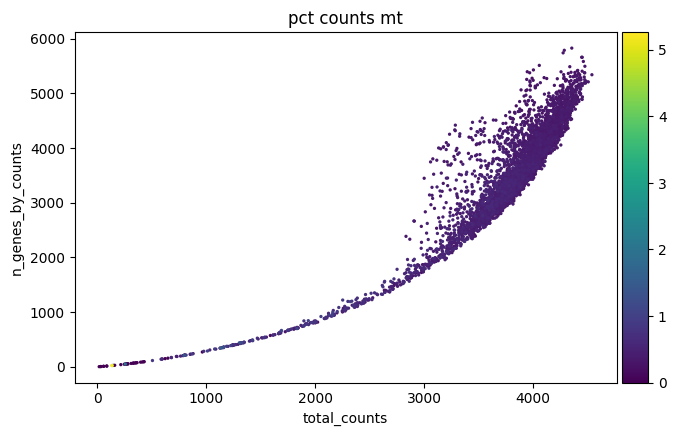

In [41]:
p1 = sns.displot(adata_s1.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata_s1, 'total_counts')
# p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata_s1, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [17]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * stats.median_abs_deviation(M)) | (
        np.median(M) + nmads * stats.median_abs_deviation(M) < M
    )
    return outlier

In [18]:
adata_s1.obs["outlier"] = (
    is_outlier(adata_s1, "log1p_total_counts", 5)
    | is_outlier(adata_s1, "log1p_n_genes_by_counts", 5)
    # | is_outlier(adata_s1, "pct_counts_in_top_20_genes", 5)
)
adata_s1.obs.outlier.value_counts()

False    110017
True       3333
Name: outlier, dtype: int64

In [20]:
adata_s1.obs["mt_outlier"] = is_outlier(adata_s1, "pct_counts_mt", 3) | (
    adata_s1.obs["pct_counts_mt"] > 8
)
adata_s1.obs.mt_outlier.value_counts()

False    102336
True      11014
Name: mt_outlier, dtype: int64

In [21]:
print(f"Total number of cells: {adata_s1.n_obs}")
adata_s1 = adata_s1[(~adata_s1.obs.outlier) & (~adata_s1.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata_s1.n_obs}")

Total number of cells: 113350


Number of cells after filtering of low quality cells: 100789


/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


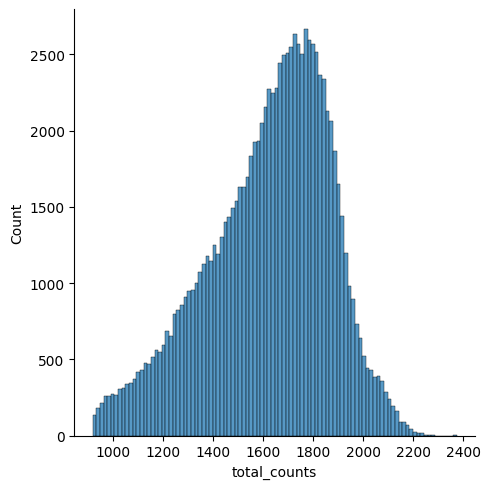

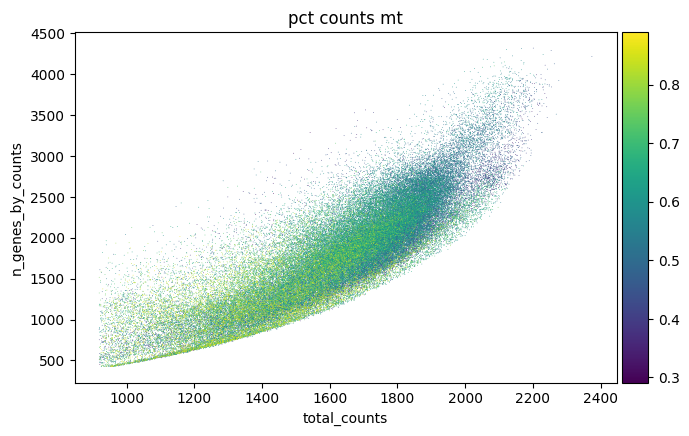

In [22]:
p1 = sns.displot(adata_s1.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata_s1, 'total_counts')
# p2 = sc.pl.violin(adata_s1, "pct_counts_mt")
p3 = sc.pl.scatter(adata_s1, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

Number of cells that contain each gene

In [14]:
pd.Series(adata_s1.var.n_cells).describe().round()

count     28798.0
mean       6701.0
std       13072.0
min           1.0
25%          47.0
50%         904.0
75%        8186.0
max      113326.0
Name: n_cells, dtype: float64

/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


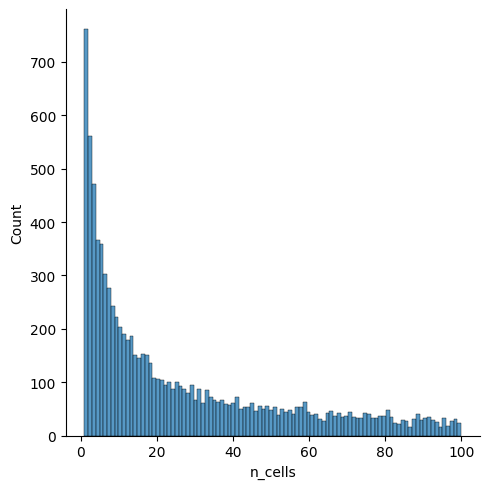

In [15]:
p1 = sns.displot(adata_s1[:,adata_s1.var["n_cells"]<=100].var["n_cells"], bins=100, kde=False)

In [16]:
print(f"Total number of genes: {adata_s1.n_vars}")

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata_s1, min_cells=20)
print(f"Number of genes after cell filter: {adata_s1.n_vars}")

Total number of genes: 28798
Number of genes after cell filter: 16342


In [17]:
# Preliminary clustering for differentiated normalisation
adata_pp = adata_s1.copy()
sc.pp.normalize_total(adata_pp, target_sum=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="groups")

/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/umap/distances.py:

In [18]:
adata_pp.X.max()

12.546049

/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


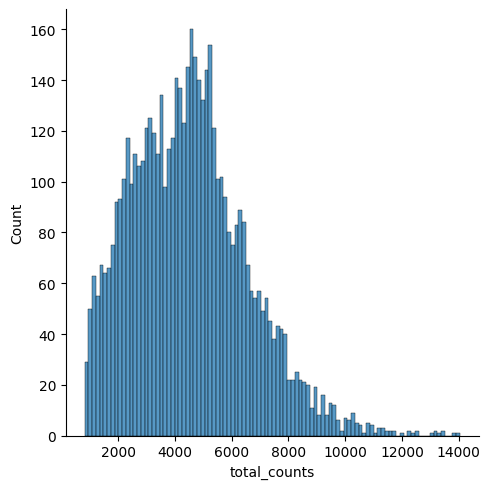

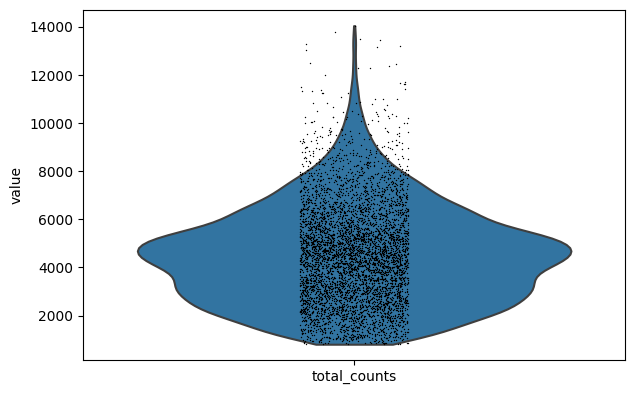

In [19]:
p1 = sns.displot(adata_pp.obs["total_counts"], bins=100, kde=False)
sc.pl.violin(adata_pp, 'total_counts')
# p2 = sc.pl.violin(adata, "pct_counts_mt")
# p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [21]:
adata_pp.obs.groups

cell_name
227_207     2
341_183     4
164_71      8
435_106     5
316_201     7
           ..
405_277    21
403_26      4
191_188     2
222_66     16
240_49      8
Name: groups, Length: 5329, dtype: category
Categories (24, object): ['0', '1', '2', '3', ..., '20', '21', '22', '23']